In [1]:
#RESNET 50 TEST
#Import statements
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'
import torch
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix


import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns
import pickle 


In [2]:
# EXTRACT DATA
files = zf.ZipFile("dataset-resized.zip",'r')
files.extractall()
files.close()

os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['paper', '.DS_Store', 'trash', 'glass', 'plastic', 'cardboard', 'metal']

In [3]:
# Splitting images into folders
## helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)
        
        
#### ORGANIZING FILES
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,"data/test")

Error: Destination path 'data/train/cardboard/cardboard69.jpg' already exists

In [4]:
## GET PATH
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=4)


In [6]:
learn50 = cnn_learner(data,models.resnet50,metrics=error_rate)

# Learn 50 10 epochs 
cnn_res50_model = learn50.fit_one_cycle(10,max_lr=5.13e-03)

saved_cnn_res50 = pickle.dumps(cnn_res50_model)

learn50.save("cnn_res50_model")

epoch,train_loss,valid_loss,error_rate,time
0,1.713067,0.800660,0.279365,38:56
1,1.821144,1.516458,0.373016,29:37
2,2.200768,1.319055,0.431746,29:51
3,2.181700,1.433043,0.507937,30:30
4,1.914011,1.299091,0.439683,31:03
5,1.526792,0.969579,0.346032,31:48
6,1.348329,0.903308,0.312698,19:22
7,1.379138,0.826128,0.288889,16:17
8,1.130489,0.663262,0.247619,16:09
9,0.922469,0.700370,0.273016,16:12


In [12]:
learn50_20 = cnn_learner(data,models.resnet50,metrics=error_rate)

# Learn 50 10 epochs 
cnn_res50_model20 = learn50_20.fit_one_cycle(20,max_lr=5.13e-03)

saved_cnn_res50_20 = pickle.dumps(cnn_res50_model20)

learn50_20.save("cnn_res50_model")

[autoreload of sklearn.utils failed: Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 266, in update_function
    setattr(old, name, getattr(new, name))
ValueError: safe_indexing() requires a code object with 0 free vars, not 2
]
[autoreload of sklearn.metrics failed: Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/anaconda3/lib/python3.7/sit

epoch,train_loss,valid_loss,error_rate,time
0,1.797067,0.702548,0.238095,29:48
1,1.445258,0.771820,0.236508,29:46
2,1.540526,0.855753,0.293651,32:51
3,1.604730,1.439590,0.415873,35:49
4,1.905037,1.097913,0.374603,36:12
5,1.828044,1.407554,0.482540,35:41
6,1.685811,1.310506,0.498413,34:45
7,1.651980,1.068435,0.403175,33:41
8,1.486439,1.000347,0.371429,21:02
9,1.376622,0.968199,0.361905,17:57


In [7]:
##### MAKE PREDICTIONS ON TEST DATA
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(path,test="test",ds_tfms=tfms,bs=4)
preds50 = learn50.get_preds(ds_type=DatasetType.Test)


##### GET Y VALUES (ACTUAL VALUES)
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)


In [8]:
    
## SAVE MOST LIKELY CLASS   
## saves the index (0 to 5) of most likely (max) predicted class for each image
max_idxs50 = np.asarray(np.argmax(preds50[0],axis=1))
yhat50 = []    
for max_idx in max_idxs50:
    yhat50.append(data.classes[max_idx])
    

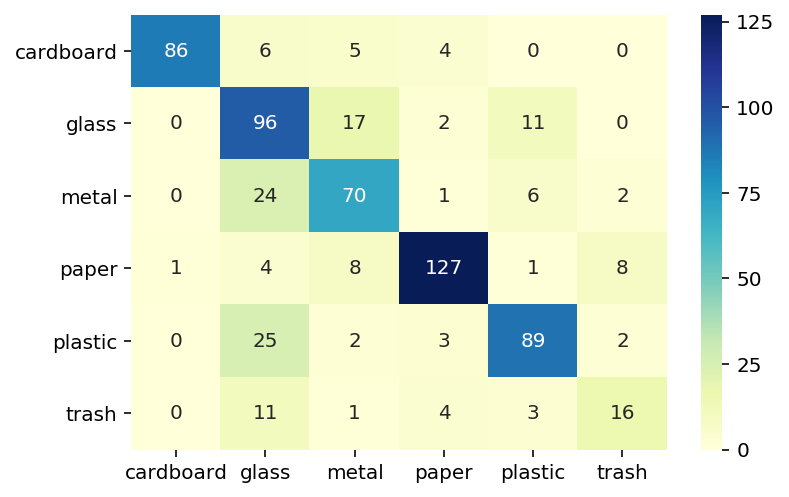

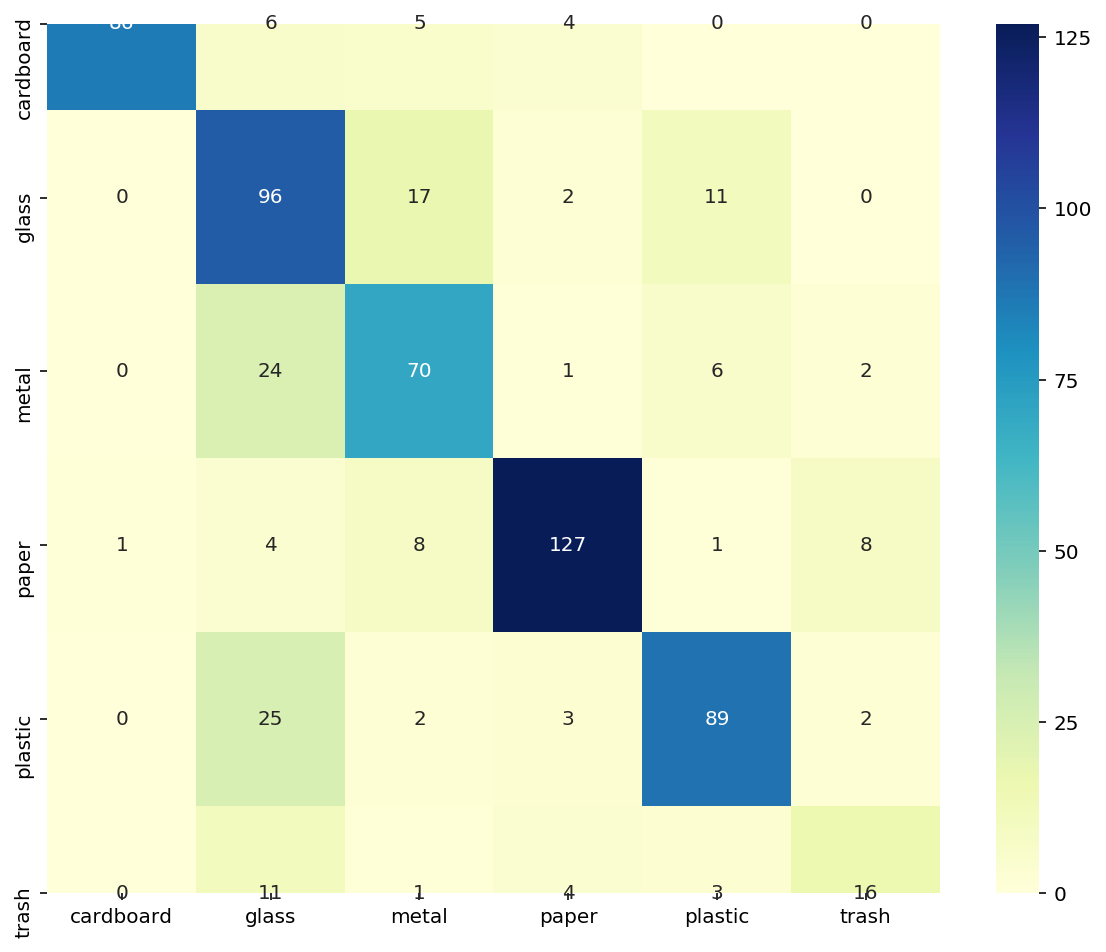

In [9]:
## CALCULATE AND VISUALIZE CONFUSION MATRIX
cm50 = confusion_matrix(y,yhat50)
# resnet50 CM
df_cm = pd.DataFrame(cm50,waste_types,waste_types)
ax = sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")

ax.set_ylim(6.0, 0.0)
plt.figure(figsize=(10,8))
sns.heatmap(df_cm,annot=True,fmt="d",cmap="YlGnBu")


In [10]:
## ACCURACY CALCULATIONS
# CORRECT FOR YHAT 50
correct50 = 0

for r in range(len(cm50)):
    for c in range(len(cm50)):
        if (r==c):
            correct50 += cm50[r,c]
            

In [11]:
## CONVERT STRINGS TO NUMBERS FOR ACCURACY CALCS
waste_types = ['trash','cardboard','glass','metal','paper','plastic']

image_actual = []
image_predicted50 = []

       
for pred in y:
    image_actual.append(waste_types.index(pred))
    
for pred in yhat50:
    image_predicted50.append(waste_types.index(pred))
    
#Accuracy resnet 50
accuracy50 = correct50/sum(sum(cm50))
print ("resnet 50 model", accuracy50)

resnet 50 model 0.7622047244094489
